# CitiBike `csp` example

Let's take a look at the CitiBike realtime data. The API is a polling JSON api, so let's look at a snapshot with `pandas`.

In [1]:
from csp_citibike import get_stations_df, get_station_status_df

In [2]:
stations = get_stations_df()
stations.head()

,lat,capacity,lon,region_id,name,short_name,station_id
0,40.712220,48,-74.010472,71,Vesey St & Church St,5216.06,06439006-11b6-44f0-8545-c9d39035f32a
1,40.719792,39,-74.005224,71,6 Ave & Walker St,5430.10,19d17911-1e4a-41fa-b62b-719aa0a6182e
2,40.774925,31,-73.982666,71,W 67 St & Broadway,7116.04,66dd4a52-0aca-11e7-82f6-3863bb44ef7c
3,40.703662,61,-74.013181,71,Whitehall St & Bridge St,4962.02,c1a4d909-0a00-475a-8e82-18ed13a4eb01
4,40.697940,23,-73.969868,71,Clinton Ave & Flushing Ave,4762.04,66dba303-0aca-11e7-82f6-3863bb44ef7c


In [3]:
statuses = get_station_status_df()
statuses.head()

,num_docks_disabled,last_reported,num_bikes_disabled,is_renting,is_returning,num_docks_available,is_installed,num_ebikes_available,station_id,num_bikes_available,total_bikes_available,lat,capacity,lon,region_id,name,short_name,num_scooters_available,num_scooters_unavailable
0,0,86400,0,0,0,0,0,0,06439006-11b6-44f0-8545-c9d39035f32a,0,0,40.712220,48,-74.010472,71,Vesey St & Church St,5216.06,NaN,NaN
1,0,1710177561,0,0,0,0,0,0,19d17911-1e4a-41fa-b62b-719aa0a6182e,0,0,40.719792,39,-74.005224,71,6 Ave & Walker St,5430.10,NaN,NaN
2,0,1712237831,0,0,0,0,0,0,66dd4a52-0aca-11e7-82f6-3863bb44ef7c,0,0,40.774925,31,-73.982666,71,W 67 St & Broadway,7116.04,NaN,NaN
3,0,1713529977,0,0,0,0,0,0,c1a4d909-0a00-475a-8e82-18ed13a4eb01,0,0,40.703662,61,-74.013181,71,Whitehall St & Bridge St,4962.02,NaN,NaN
4,0,1713660191,0,1,1,37,1,1,bc5235a5-7f10-4a27-806e-9c25fa700959,3,4,40.814326,41,-73.959025,71,Broadway & Moylan Pl,7823.03,0.0,0.0


Let's plot a scatter plot of station lat/long colored by capacity, and then a second by availability

In [4]:
import seaborn as sns
sns.set(style='ticks')

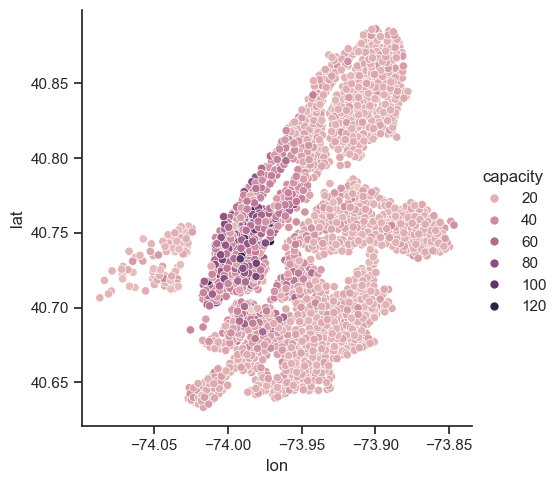

In [5]:
sns.relplot(stations, x="lon", y="lat", hue="capacity")

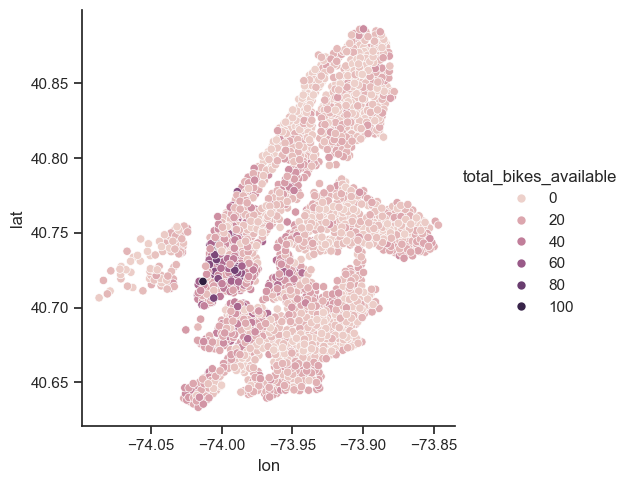

In [6]:
sns.relplot(statuses, x="lon", y="lat", hue="total_bikes_available")

## Now let's build a simple `csp` node to poll for this data


In [7]:
import csp
from csp import ts
from datetime import timedelta
from csp_citibike import get_station_status

First, let's build a node to poll the data using `csp.alarm`

In [8]:
@csp.node
def poll_data(interval: timedelta) -> ts[[dict]]:
    with csp.alarms():
        # this line tells `csp` we will have an alarm
        # we will schedule the alarm in a later step
        a_poll = csp.alarm(bool)

    with csp.start():
        # poll immediately after starting
        # by passing timedelta(seconds=0)
        csp.schedule_alarm(a_poll, timedelta(), True)

    if csp.ticked(a_poll):
        # grab the data
        to_return = get_station_status()

        # schedule next poll in `interval`
        csp.schedule_alarm(a_poll, interval, True)
        return to_return

Now, let's build a simple node to accumulate the total capacity of the system

In [9]:
@csp.node
def calculate_total_system_capacity(stations: ts[[dict]]) -> ts[int]:
    with csp.state():
        # these are stateful variables that will retain their
        # value in between "ticks"
        s_capacity = 0
        s_stations = {}

    if csp.ticked(stations):
        # when a new list of stations "ticks", we'll do some
        # processing and emit a new "tick" as output
        for station in stations:
            # subtract prior capacity
            prior_capacity = s_stations.get(station["station_id"], {}).get("total_bikes_available", 0)
            s_capacity -= prior_capacity
    
            # now update our tracker and capacity
            s_stations[station["station_id"]] = station
            s_capacity += station["total_bikes_available"]
    
        # finally, "tick" out the result
        return s_capacity
        

Finally, lets tie together our data fetcher and our system capacity calculator in a `csp.graph`

In [10]:
@csp.graph
def my_capacity_calculator(interval: timedelta):
    stations_data = poll_data(interval=interval)
    system_capacity = calculate_total_system_capacity(stations_data)
    csp.print("Total system capacity", system_capacity)

Now its time to run! Let's pass in a polling interval of `60s`

In [ ]:
csp.run(my_capacity_calculator, timedelta(60), realtime=True)

2024-04-21 00:46:03.452912 Total system capacity:31701
